## Install Package

In [0]:
pip install investpy

## Import Packages

In [0]:
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import math
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import warnings

warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')
fig = (12,6)

## Load Data

In [4]:
import investpy
df = investpy.get_stock_historical_data('ECO',country='colombia',
                                   from_date='01/01/2014', 
                                  #  to_date = datetime.today().strftime('%d/%m/%Y'),
                                   to_date = '01/02/2020',
                                   interval='Daily')
df.tail()

,Open,High,Low,Close,Volume,Currency
Date,,,,,,
2020-01-27,3285.0,3285.0,3195.0,3205.0,17911844,COP
2020-01-28,3210.0,3220.0,3190.0,3190.0,9741845,COP
2020-01-29,3200.0,3215.0,3185.0,3195.0,6951412,COP
2020-01-30,3180.0,3200.0,3145.0,3200.0,9469906,COP
2020-01-31,3210.0,3210.0,3140.0,3180.0,19502920,COP


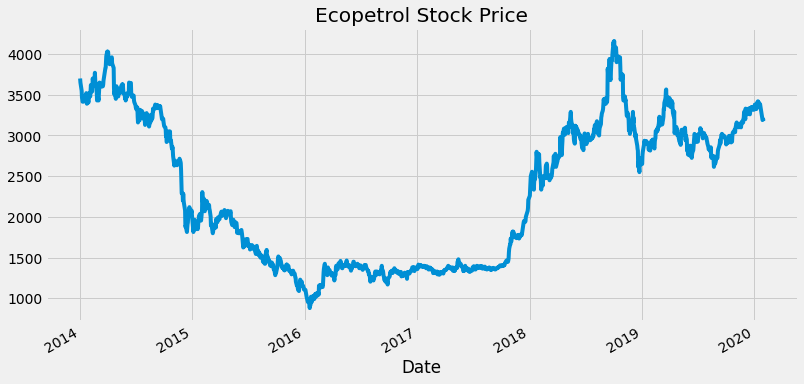

In [5]:
# Historical Price
df['Close'].plot(figsize=fig)
plt.title('Ecopetrol Stock Price');

## Log Return, Cumulative Return and Drawdown

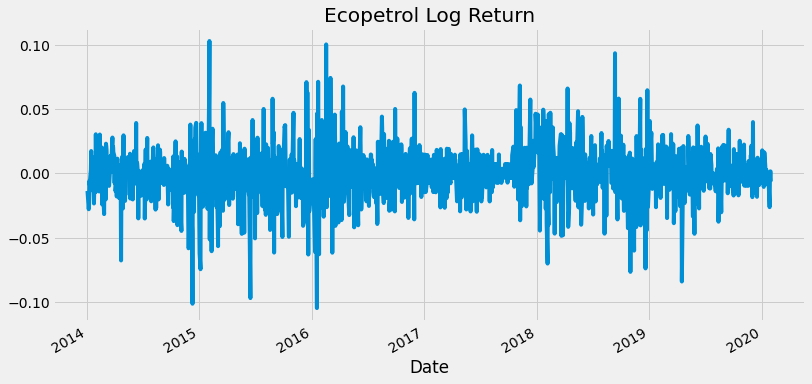

In [6]:
# Log Return
np.log(df.Close/df.Close.shift(1)).plot(figsize=fig)
plt.title('Ecopetrol Log Return');

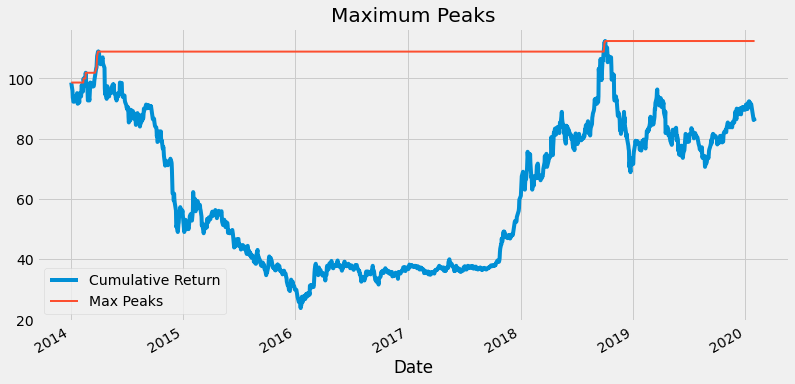

In [7]:
# Max Peaks
rets = df.Close.pct_change()
cum_ret =  100*(1 + rets).cumprod()
cum_ret.plot(label='Cumulative Return',figsize=fig,legend=True)
previous_peaks = cum_ret.cummax()
previous_peaks.plot(label='Max Peaks', lw=2,legend=True)
plt.title('Maximum Peaks');

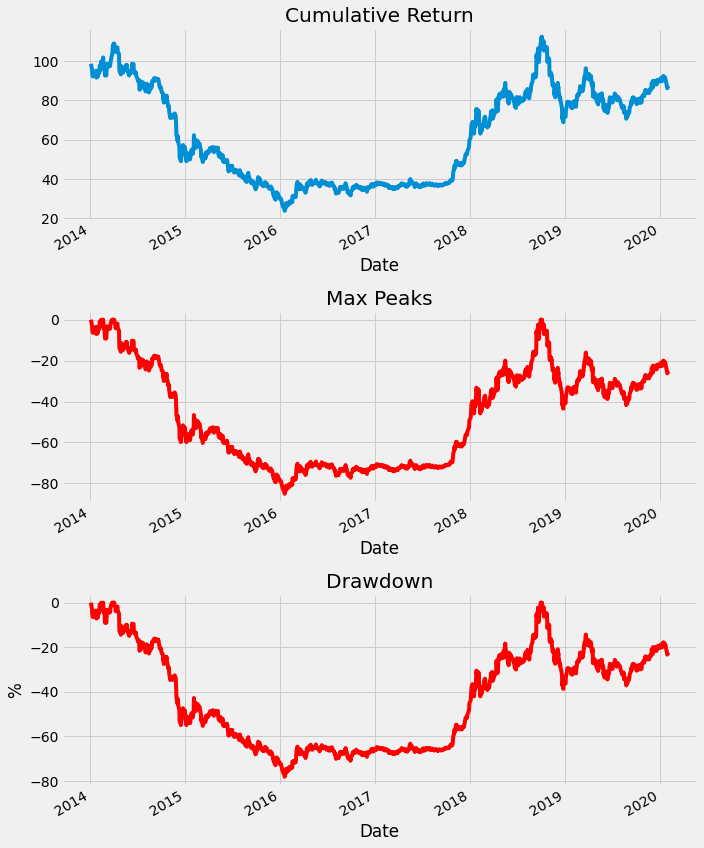

In [8]:
# Drawdown
f, ax = plt.subplots(3,figsize=(10,12))
cum_ret.plot(ax=ax[0],title='Cumulative Return')
(cum_ret-previous_peaks).plot(ax=ax[1], c='r',title='Max Peaks')
drawdown = (cum_ret - previous_peaks) / previous_peaks
(drawdown*100).plot(ax=ax[2],c='r',title='Drawdown')
ax[2].set_ylabel("%")
f.tight_layout();

In [9]:
# Max Drawdown
print('Max drawdown: {}%' .format(round(drawdown.min(),2)*100))
print('Date max drawdown: {}'.format(drawdown.idxmin()))

Max drawdown: -78.0%
Date max drawdown: 2016-01-18 00:00:00


In [10]:
# Max Drawdown by Date
print('Max drawdown: {}%' .format(round(drawdown['2018':'2019'].min(),2)*100))
print('Date max drawdown: {}'.format(drawdown['2018':'2019'].idxmin()))

Max drawdown: -44.0%
Date max drawdown: 2018-01-02 00:00:00


## Long Short Term Memory (LSTM)

In [0]:
# Close Price
data = df.filter(['Close'])
# Convert the dataframe to a numpy array
close_price = data.values
# Split Data
split_data = math.ceil(len(close_price)*0.8)

In [0]:
# Normalize Data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_price = scaler.fit_transform(close_price)

In [0]:
# Split Data to Train and Test
train_data = scaled_price[:split_data]
test_data = scaled_price[split_data:]

In [0]:
# Split the data into x_train and y_train
x_train = []
y_train = []

for i in range(90, len(train_data)):
    x_train.append(train_data[i-90:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

In [15]:
# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1096, 90, 1)

In [0]:
# LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences= False))
model.add(Dense(25))
model.add(Dense(1))

In [0]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [18]:
# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=30)

Epoch 1/30
1096/1096 [==============================] - 58s 53ms/step - loss: 0.0030
Epoch 2/30
1096/1096 [==============================] - 60s 54ms/step - loss: 0.0012
Epoch 3/30
1096/1096 [==============================] - 58s 53ms/step - loss: 9.5138e-04
Epoch 4/30
1096/1096 [==============================] - 59s 54ms/step - loss: 8.5751e-04
Epoch 5/30
1096/1096 [==============================] - 59s 54ms/step - loss: 5.1203e-04
Epoch 6/30
1096/1096 [==============================] - 57s 52ms/step - loss: 4.7000e-04
Epoch 7/30
1096/1096 [==============================] - 58s 53ms/step - loss: 4.8176e-04
Epoch 8/30
1096/1096 [==============================] - 58s 53ms/step - loss: 4.7891e-04
Epoch 9/30
1096/1096 [==============================] - 58s 53ms/step - loss: 4.4972e-04
Epoch 10/30
1096/1096 [==============================] - 58s 53ms/step - loss: 4.3049e-04
Epoch 11/30
1096/1096 [==============================] - 59s 53ms/step - loss: 3.8325e-04
Epoch 12/30
1096/1096 [====

In [0]:
#Create the testing data set 
test_data = scaled_price[split_data-90:]
#Create the data sets x_test and y_test
x_test = []
y_test = close_price[split_data:, :]
for i in range(90, len(test_data)):
    x_test.append(test_data[i-90:i, 0])

x_test = np.array(x_test)

In [0]:
# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

In [0]:
# Get predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [38]:
# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

82.47111200971078

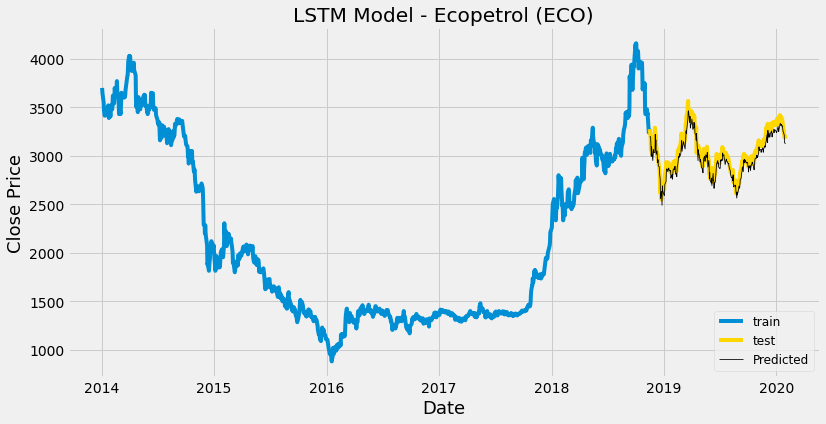

In [34]:
# Plot the data
train = data[:split_data]
valid = data[split_data:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=fig)
plt.title('LSTM Model - Ecopetrol (ECO)')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid['Close'],lw=4, c='gold')
plt.plot(valid['Predictions'],lw=0.8, c='black')
plt.legend(['train', 'test', 'Predicted'], loc='lower right',fontsize=12);

## Next day Prediction

In [0]:
# "data" -> Historical Stock Price 
last_90_days = data[-90:].values

In [0]:
# Normalize
scaled_90_days = scaler.transform(last_90_days)
x_test1 = []
x_test1.append(scaled_90_days)
# Convert to array
x_test1 = np.array(x_test1)
# Reshape
x_test1 = np.reshape(x_test1, (x_test1.shape[0], x_test1.shape[1], 1))
# Predict
predict_price = model.predict(x_test1)
predict_price = scaler.inverse_transform(predict_price)

## Check Next day Prediction

In [32]:

ecopetrol = investpy.get_stock_historical_data('ECO',country='colombia',
                                   from_date='31/01/2020',                          
                                   to_date = '03/02/2020',
                                   interval='Daily')
ecopetrol

,Open,High,Low,Close,Volume,Currency
Date,,,,,,
2020-01-31,3210.0,3210.0,3140.0,3180.0,19502920,COP
2020-02-03,3160.0,3160.0,3120.0,3140.0,7113412,COP


In [36]:
print('Real Close Price vs. Prediction:','\n')
print('Real: ', ecopetrol.Close.iloc[-1])
print('Prediction: {:.2f}'.format(float(predict_price)))
print('Difference: {:.2f}%'.format((float(predict_price)/ecopetrol.Close.iloc[-1] - 1)*100))

Real Close Price vs. Prediction: 

Real:  3140.0
Prediction: 3108.30
Difference: -1.01%
